In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_csv('../data/historical_data/master_historical_data.csv', index_col = 0)

/usr/lib64/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Modeling of ridership

In [3]:
#### Now let's do some modeling
## We'll model total ridership across the whole network to understand global trends.
## We'll also build models for individual stations using the features determined above whenever possible. 
## Some stations do not vary much, so it's likely that they will not be able to utilize these features and will require a simpler model (maybe an EWMA).

### Total ridership

In [4]:
## This is a relatively simple problem, so we'll take a relatively simple approach to solving it. 
## A simple linear regression would likely work fine, but a random forest model will probably have better predictive capabilities.
## We'll plan to go with three models: 1) a linear regression model, 2) a simple random forest model, and 3) a gradient-boosted decision tree model.

In [5]:
## We've already done some feature pruning by assessing the degree to which certain features are correlated, so we'll go from there.
## Make a subset with just the data we care about (continuous features: precipIntensity, apparentTemperature, humidity, windSpeed; categorical features: precipType, working_day, hour, month)
df_sub = df[['start_datetime', 'precipIntensity', 'apparentTemperature', 'humidity', 'windSpeed', 'precipType', 'working_day', 'hour', 'month']].copy()
## Set the index as the datetime of the ride
df_sub.set_index('start_datetime', inplace = True, drop = True)
df_sub.index = pd.to_datetime(df_sub.index)
df_sub.sort_index(inplace = True)
df_sub.head()

,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month
start_datetime,,,,,,,,
2011-01-01 00:01:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:02:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:06:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:09:00,0.0,31.1,0.82,4.88,none,0,0,1
2011-01-01 00:28:00,0.0,31.1,0.82,4.88,none,0,0,1


In [6]:
print(df_sub.shape)
print(df_sub.isnull().sum())

(15000336, 8)
precipIntensity         271
apparentTemperature     271
humidity                271
windSpeed              1448
precipType                0
working_day               0
hour                      0
month                     0
dtype: int64


In [7]:
## Since there are so few nulls we will just drop them
df_sub.dropna(inplace = True)

In [8]:
## We need to label encode the categoricals. The only one that hasn't already been done is precipType, so we'll do that here.
## Get all the different precip types
precipType_labels = df_sub.precipType.unique().tolist()
## Instantiate the encoder
precipType_label_encoder = {}
## Assign a unique integer for each precip type
for i, label in enumerate(precipType_labels):
    precipType_label_encoder[str(label)] = int(i)
print(precipType_label_encoder)
## Encode the labels
df_sub['precipType'] = df_sub.precipType.apply(lambda x: precipType_label_encoder[x])
df_sub.head()

{'snow': 2, 'none': 0, 'rain': 1}


,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month
start_datetime,,,,,,,,
2011-01-01 00:01:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:02:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:06:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:09:00,0.0,31.1,0.82,4.88,0,0,0,1
2011-01-01 00:28:00,0.0,31.1,0.82,4.88,0,0,0,1


In [ ]:
## Now let's bin the data into 10 minute intervals and get ride counts per interval
df_sub.reset_index(inplace = True)
## Bin into 10 minute bins
df_sub['start_datetime'] = df_sub.start_datetime.apply(lambda x: x - datetime.timedelta(minutes = x.minute % 10))
## Groupby datetime and get counts (number of rides)
df_sub_rides = df_sub[['start_datetime', 'hour']].groupby('start_datetime', as_index = False).count()
df_sub_rides.columns = ['start_datetime', 'rides']
## Get the first instance of a bin and set that as the data for joining
df_sub_first = df_sub.groupby('start_datetime', as_index = False).first()
## Join on datetime
df_sub = df_sub_rides.merge(df_sub_first, on = 'start_datetime', how = 'left')
## Let's fill in the bins that are missing
## Make a date range
date_range = pd.date_range(start = df_sub.start_datetime.iloc[0], end = df_sub.start_datetime.iloc[-1], freq = '10min')
## Make a df of zeroes with the date range as the index
df_dr = pd.DataFrame([0]*date_range.shape[0], columns=['rides'], index = date_range)
df_dr.reset_index(inplace = True)
df_dr.columns = ['start_datetime', 'rides']
## Join with df_sub
df_sub = df_dr.merge(df_sub, how = 'left', on = 'start_datetime')
## Fill in the time bins without any rides (NaNs in rides_y) with zeroes
df_sub.rides_y.loc[df_sub.rides_y.isnull()] = 0
## Make rides column from rides_y
df_sub['rides'] = df_sub['rides_y']
## Drop rides_x and rides_y
df_sub.drop(['rides_x', 'rides_y'], inplace = True, axis = 1)
## Forward fill weather NaNs
df_sub['precipIntensity'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['apparentTemperature'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['humidity'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['windSpeed'].fillna(method = 'ffill', axis = 0, inplace = True)
df_sub['precipType'].fillna(method = 'ffill', axis = 0, inplace = True)
## Fill in the hour and month
df_sub['hour'] = df_sub['start_datetime'].apply(lambda x: x.hour)
df_sub['month'] = df_sub['start_datetime'].apply(lambda x: x.month)
## Fill in the working_day
holidays = pd.read_csv('../data/holidays.csv', index_col = 0)
df_sub['working_day'] = df_sub.start_datetime.apply(lambda x: 0 if x.strftime('%Y-%m-%d') in holidays.date.tolist() else 1)
df_sub.set_index('start_datetime', inplace = True, drop = True)
# df_sub.to_csv('../data/historical_data_for_models.csv', sep = ',')
df_sub.head()

In [2]:
df_sub = pd.read_csv('../data/historical_data_for_models.csv', index_col = 0)
df_sub.index = pd.to_datetime(df_sub.index)
df_sub.head()

,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month,rides
start_datetime,,,,,,,,,
2011-01-01 00:00:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0
2011-01-01 00:10:00,0.0,31.1,0.82,4.88,0.0,1,0,1,0.0
2011-01-01 00:20:00,0.0,31.1,0.82,4.88,0.0,1,0,1,1.0
2011-01-01 00:30:00,0.0,31.1,0.82,4.88,0.0,1,0,1,3.0
2011-01-01 00:40:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0


(35000, 65000)

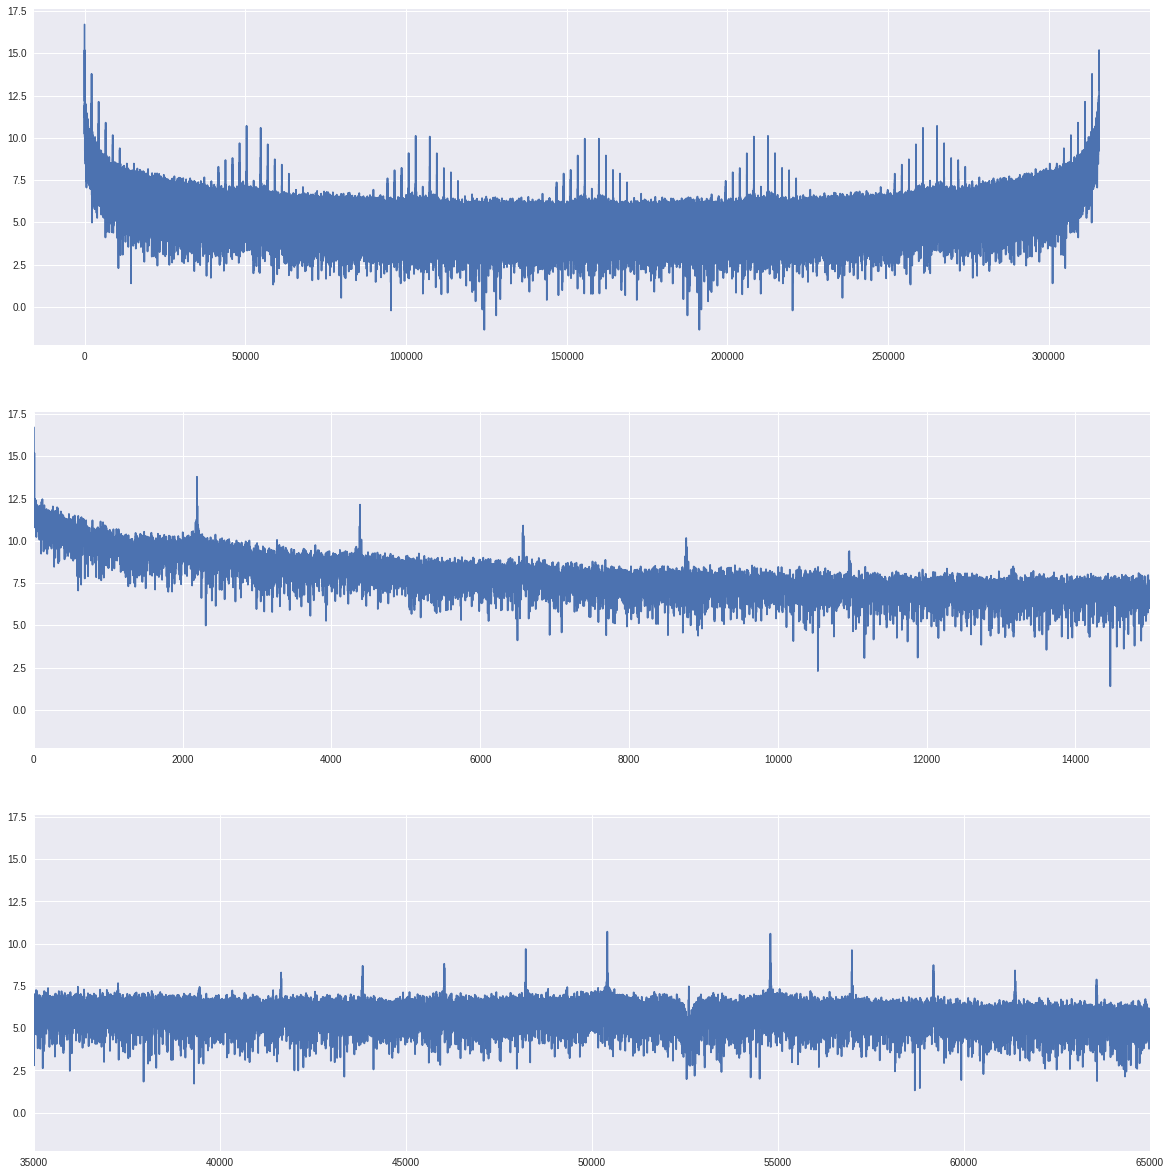

In [5]:
## Since we are dealing with timecourse data we saw that there are periodic trends in the data at various levels: yearly, monthly, weekly, and daily.
## Let's apply an FFT just to have numerical evidence along with our previous visual evidence
plt.figure(figsize = [20,21])
fft = np.fft.fft( df_sub['apparentTemperature'])
plt.subplot(3,1,1)
plt.plot(np.log(np.abs(fft)))
plt.subplot(3,1,2)
plt.plot(np.log(np.abs(fft)))
plt.xlim([-1,15000])
plt.subplot(3,1,3)
plt.plot(np.log(np.abs(fft)))
plt.xlim([35000,65000])

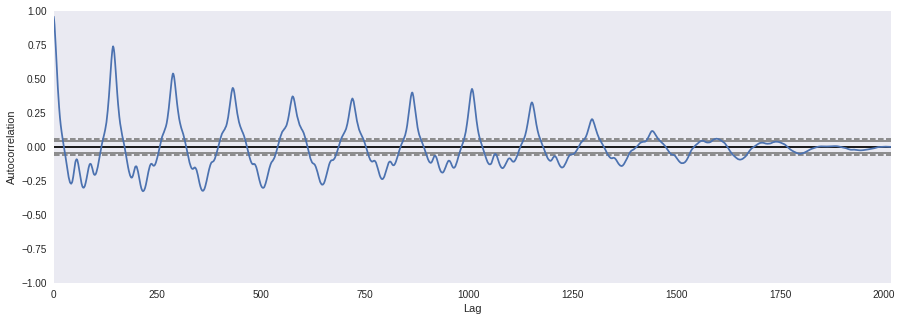

In [37]:
## Let's also look at the autocorrelation of the time series
plt.figure(figsize = [15,5])
pd.tools.plotting.autocorrelation_plot(df_sub['2016-01-01':'2016-01-014'].rides)

In [38]:
## There is clearly periodicity in the data, as we expected from our visual analysis. We can implement this as one or more features.
## Let's add some time lags as features
df_sub['lag_10m'] = df_sub.rides.shift(1)
df_sub['lag_20m'] = df_sub.rides.shift(2)
df_sub['lag_30m'] = df_sub.rides.shift(3)
df_sub['lag_40m'] = df_sub.rides.shift(4)
df_sub['lag_50m'] = df_sub.rides.shift(5)
df_sub['lag_60m'] = df_sub.rides.shift(6)
df_sub['lag_12h'] = df_sub.rides.shift(72)
df_sub['lag_24h'] = df_sub.rides.shift(144)
df_sub['lag_1w'] = df_sub.rides.shift(1008)
df_sub['lag_6mo'] = df_sub.rides.shift(26280) ## This doesn't account for leap years, but it shouldn't affect the prediction much
df_sub['lag_1y'] = df_sub.rides.shift(52560) ## This doesn't account for leap years, but it shouldn't affect the prediction much
df_sub.head()

,precipIntensity,apparentTemperature,humidity,windSpeed,precipType,working_day,hour,month,rides,lag_10m,lag_20m,lag_30m,lag_40m,lag_50m,lag_60m,lag_12h,lag_24h,lag_1w,lag_6mo,lag_1y
start_datetime,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:10:00,0.0,31.1,0.82,4.88,0.0,1,0,1,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:20:00,0.0,31.1,0.82,4.88,0.0,1,0,1,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:30:00,0.0,31.1,0.82,4.88,0.0,1,0,1,3.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-01 00:40:00,0.0,31.1,0.82,4.88,0.0,1,0,1,4.0,3.0,1.0,0.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
## Let's subset the data again to make a train and a test set.
## Since we added lags up to 1 year and the data start at 2011 let's take 2012-2014 as our training set and 2015 as our test set (2016 is an incomplete year)
# df_sub.set_index('start_datetime', inplace = True, drop = True)
train_X = df_sub['2012':'2014'].copy()
train_y = train_X.rides
train_X.drop('rides', axis = 1, inplace = True)
test_X = df_sub['2015'].copy()
test_y = test_X.rides
test_X.drop('rides', axis = 1, inplace = True)

In [2]:
## Import the libraries for modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import scipy as sp

/usr/lib64/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/lib64/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


The average root mean squared error is 11.2441800917 +/- 1.86589514828
The average percent of variance explained by the model is 0.935475657242 +/- 0.0108536808442


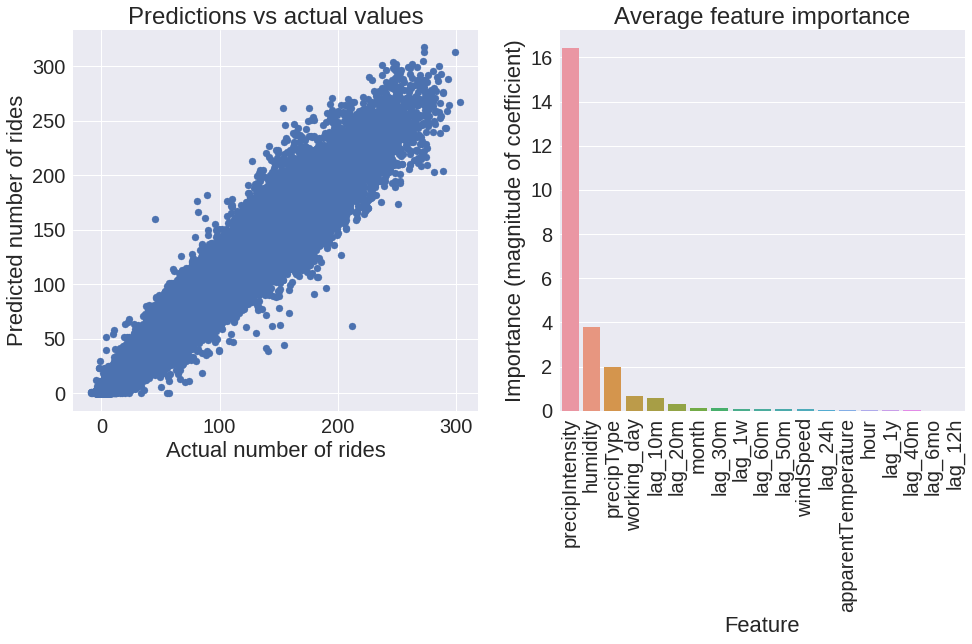

In [26]:
## First do a cross-validated linear regression to make sure it performs appropriately
## Make the cross validation splitter
tscv = TimeSeriesSplit(n_splits=10)
## Define the function do do the regression fitting and predicting
def doCV(tr_X, tr_y, ts_X):
    lr = LinearRegression(n_jobs = -1)
    lr.fit(tr_X, tr_y)
    lr_preds = lr.predict(ts_X)
    return lr, lr_preds
## Fit and predict the splits
lr_rmse = []
lr_variance = []
lr_coefs = []
X_trains = []
y_trains = []
X_tests = []
y_tests = []
lrs = []
lr_preds = []
for train_index, test_index in tscv.split(train_X):
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    y_trains.append(y_train)
    y_tests.append(y_test)
    lr, lr_pred = doCV(X_train, y_train, X_test)
    lrs.append(lr)
    lr_preds.append(lr_pred)
    lr_rmse.append(np.sqrt(np.mean((lr_pred - y_test) ** 2)))
    lr_coefs.append(lr.coef_)
    lr_variance.append(lr.score(X_test, y_test))

print("The average root mean squared error is", np.mean(lr_rmse), "+/-", np.std(lr_rmse))
print("The average percent of variance explained by the model is", np.mean(lr_variance), "+/-", np.std(lr_variance))
sns.set(font_scale = 2)
plt.figure(figsize = [16,7])
plt.subplot(1,2,1)
plt.scatter(lrs[-1].predict(test_X), test_y)
plt.title('Predictions vs actual values')
plt.ylabel('Predicted number of rides')
plt.xlabel('Actual number of rides')
plt.subplot(1,2,2)
coefs = pd.DataFrame([(x,y) for (y,x) in sorted(zip(np.abs(np.mean(np.array(lr_coefs), axis = 0)), X_train.columns), reverse = True)], 
                     columns = ['Feature', 'Importance (magnitude of coefficient)'])
sns.barplot(x = 'Feature', y = 'Importance (magnitude of coefficient)', data = coefs)
plt.xticks(rotation=90)
plt.title('Average feature importance')
plt.ylabel('Importance (magnitude of coefficient)')

In [ ]:
## A linear regression does pretty well. The top 5 features for this model are precipIntensity, humidity, precipType, working_day, and lag_10m.

In [ ]:
## Let's see how a random forest does.
## Make a time series cv split
tscv = TimeSeriesSplit(n_splits=3)

## Instantiate the estimator
rf = RandomForestRegressor(n_estimators = 100, n_jobs = 1, oob_score = True)

## Set the parameter ranges
params = {
    'n_estimators': [10, 30, 100],
    'max_depth': [3, 6, 12],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'min_weight_fraction_leaf': [0, 1e-4, 1e-1, 0.1, 0.5],
}
## Make the grid search model
gscv = GridSearchCV(rf, params, n_jobs = -1, refit = True, cv = tscv, verbose = 1, return_train_score = False)
## Do the grid search
gscv.fit(train_X, train_y)
# rf.fit(train_X, train_y)

In [156]:
print(gscv.best_params_)

{'min_samples_split': 8, 'n_estimators': 115, 'min_weight_fraction_leaf': 0, 'max_depth': 20, 'min_samples_leaf': 3}


In [151]:
## Further refine parameters based on the initial results
## Set the parameter ranges
params = {
    'n_estimators': [80, 115, 150],
    'max_depth': [12, 20, None],
    'min_samples_split': [6, 8, 16, 32],
    'min_samples_leaf': [1, 2, 3],
    'min_weight_fraction_leaf': [0, 0.1],
}
## Make the grid search model
gscv = GridSearchCV(rf, params, n_jobs = -1, refit = True, cv = tscv, verbose = 1, return_train_score = False)
## Do the grid search
gscv.fit(train_X, train_y)
# rf.fit(train_X, train_y)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 50.2min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed: 78.1min finished


GridSearchCV(cv=TimeSeriesSplit(n_splits=3), error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [80, 115, 150], 'min_samples_split': [6, 8, 16, 32], 'min_weight_fraction_leaf': [0, 0.1], 'max_depth': [12, 20, None], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring=None, verbose=1)

In [157]:
print(gscv.best_params_)

{'min_samples_split': 8, 'n_estimators': 115, 'min_weight_fraction_leaf': 0, 'max_depth': 20, 'min_samples_leaf': 3}


The average root mean squared error is 10.5448711005 +/- 1.74208988751
The average percent of variance explained by the model is 0.943091669873 +/- 0.0105071620753


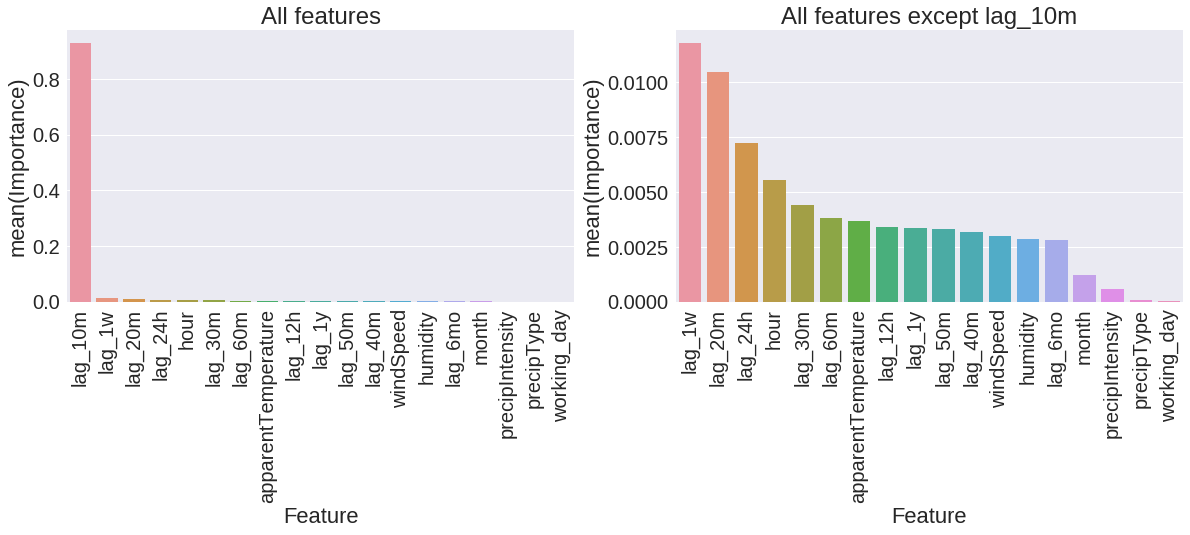

In [28]:
## Let's look at the feature importances with cross validation
## Make the cross validation splitter
tscv = TimeSeriesSplit(n_splits=10)
## Define the function do do the regression fitting and predicting
def doCV(tr_X, tr_y, ts_X):
    rf = RandomForestRegressor(n_estimators = 115, min_samples_split = 8, min_weight_fraction_leaf = 0, max_depth = 20, min_samples_leaf = 3, n_jobs = -1, oob_score = True)
    rf.fit(tr_X, tr_y)
    rf_preds = rf.predict(ts_X)
    return rf, rf_preds
## Fit and predict the splits
rf_rmse = []
rf_variance = []
rf_coefs = []
X_trains = []
y_trains = []
X_tests = []
y_tests = []
rfs = []
rf_preds = []
for train_index, test_index in tscv.split(train_X):
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    y_trains.append(y_train)
    y_tests.append(y_test)
    rf, rf_pred = doCV(X_train, y_train, X_test)
    rfs.append(rf)
    rf_preds.append(rf_pred)
    rf_rmse.append(np.sqrt(np.mean((rf_pred - y_test) ** 2)))
    rf_coefs.append(rf.feature_importances_)
    rf_variance.append(rf.score(X_test, y_test))

coefs = pd.DataFrame([(x,y) for (y,x) in sorted(zip(np.abs(np.mean(np.array(rf_coefs), axis = 0)), train_X.columns), reverse = True)], 
                     columns = ['Feature', 'Importance'])
plt.figure(figsize = [20,5])
plt.subplot(1,2,1)
sns.barplot(x = 'Feature', y = 'Importance', data = coefs)
plt.xticks(rotation=90)
plt.title('All features')
plt.subplot(1,2,2)
sns.barplot(x = 'Feature', y = 'Importance', data = coefs.loc[coefs.Feature != 'lag_10m'])
plt.xticks(rotation=90)
plt.title('All features except lag_10m')
print("The average root mean squared error is", np.mean(rf_rmse), "+/-", np.std(rf_rmse))
print("The average percent of variance explained by the model is", np.mean(rf_variance), "+/-", np.std(rf_variance))

In [ ]:
## Interestingly the feature importances for the linear regression and the random forest are noticeably different.
## The top features for the random forest area lag_10m (by a huge margin), lag_1w, lag_20m, lag_24h, and hour
## The random forest model does a bit better with a ~6% decrease in the RMSE and a very slight increase in R^2. 
## The gains seen by the random forest over the linear regression come at a very large increase in computation time and power, so let's see how it performs with just the top 5 features.

The average root mean squared error is 10.8657598011 +/- 1.81157314654
The average percent of variance explained by the model is 0.939768392798 +/- 0.010123366643


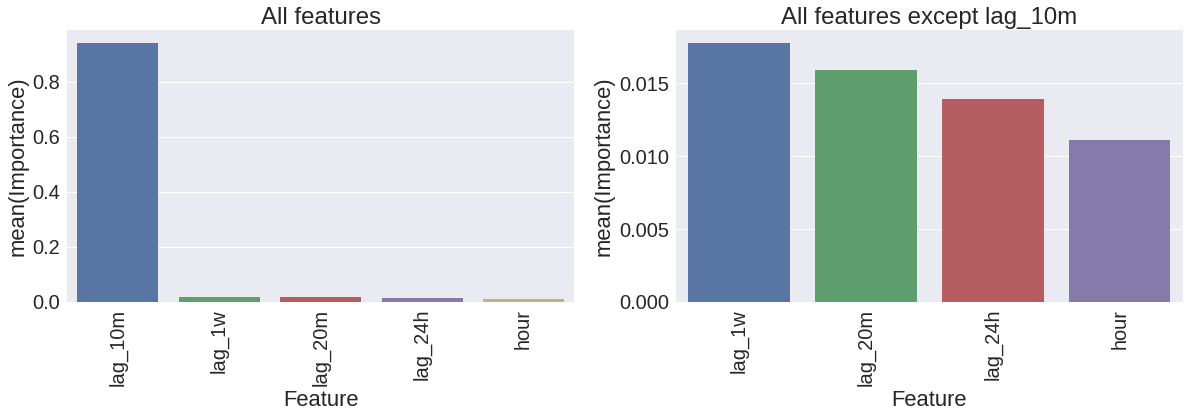

In [29]:
## Let's look at the feature importances with cross validation
## Make the cross validation splitter
tscv = TimeSeriesSplit(n_splits=10)
## Define the function do do the regression fitting and predicting
def doCV(tr_X, tr_y, ts_X):
    rf = RandomForestRegressor(n_estimators = 115, min_samples_split = 8, min_weight_fraction_leaf = 0, max_depth = 20, min_samples_leaf = 3, n_jobs = -1, oob_score = True)
    rf.fit(tr_X, tr_y)
    rf_preds = rf.predict(ts_X)
    return rf, rf_preds
## Fit and predict the splits
rf_rmse = []
rf_variance = []
rf_coefs = []
X_trains = []
y_trains = []
X_tests = []
y_tests = []
rfs = []
rf_preds = []
for train_index, test_index in tscv.split(train_X[['lag_10m', 'lag_1w', 'lag_20m', 'lag_24h', 'hour']]):
    X_train, X_test = train_X[['lag_10m', 'lag_1w', 'lag_20m', 'lag_24h', 'hour']].iloc[train_index], train_X[['lag_10m', 'lag_1w', 'lag_20m', 'lag_24h', 'hour']].iloc[test_index]
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    y_trains.append(y_train)
    y_tests.append(y_test)
    rf, rf_pred = doCV(X_train, y_train, X_test)
    rfs.append(rf)
    rf_preds.append(rf_pred)
    rf_rmse.append(np.sqrt(np.mean((rf_pred - y_test) ** 2)))
    rf_coefs.append(rf.feature_importances_)
    rf_variance.append(rf.score(X_test, y_test))

coefs = pd.DataFrame([(x,y) for (y,x) in sorted(zip(np.abs(np.mean(np.array(rf_coefs), axis = 0)), train_X[['lag_10m', 'lag_1w', 'lag_20m', 'lag_24h', 'hour']].columns), reverse = True)], 
                     columns = ['Feature', 'Importance'])
plt.figure(figsize = [20,5])
plt.subplot(1,2,1)
sns.barplot(x = 'Feature', y = 'Importance', data = coefs)
plt.xticks(rotation=90)
plt.title('All features')
plt.subplot(1,2,2)
sns.barplot(x = 'Feature', y = 'Importance', data = coefs.loc[coefs.Feature != 'lag_10m'])
plt.xticks(rotation=90)
plt.title('All features except lag_10m')
print("The average root mean squared error is", np.mean(rf_rmse), "+/-", np.std(rf_rmse))
print("The average percent of variance explained by the model is", np.mean(rf_variance), "+/-", np.std(rf_variance))

In [ ]:
## We see a slight increase in the MSE and a slight decrease in the R^2 when limiting to only 5 features.
## The computation time was shorter, but nowhere near as short as the linear regression. I'm inclined to go with the linear regression here.

In [ ]:
## Now let's go in the opposite direction in terms of computation time and try xgboost for fun just to see how high we can get the scores.

In [211]:
## Make a time series cv split
tscv = TimeSeriesSplit(n_splits=10)

## Set up the parameters for the estimator
params = {
    'n_estimators': 30,
    'max_depth': 20,
    'gamma': 0,
    'min_child_weight': 1,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'lambda': 1,
    'alpha': 0,
    'learning_rate': 0.1
}
xgb_train = xgb.DMatrix(train_X, label=train_y, feature_names=train_X.columns)

## Instantiate the estimator
xrf = xgb.cv(params, xgb_train, num_boost_round = 200, nfold = 10, folds = tscv.split(train_X, train_y), metrics = ('rmse'), early_stopping_rounds=20, verbose_eval=2)

[0]	train-rmse:62.4508+1.64749	test-rmse:60.6008+15.2907
[2]	train-rmse:51.0786+1.32175	test-rmse:49.6034+12.5688
[4]	train-rmse:41.892+1.07748	test-rmse:40.7351+10.336
[6]	train-rmse:34.5082+0.861629	test-rmse:33.6889+8.52786
[8]	train-rmse:28.5836+0.707821	test-rmse:28.1075+7.04687
[10]	train-rmse:23.8358+0.587076	test-rmse:23.7423+5.84999
[12]	train-rmse:20.0281+0.485443	test-rmse:20.3808+4.8951
[14]	train-rmse:16.9541+0.40815	test-rmse:17.8193+4.15591
[16]	train-rmse:14.4664+0.343207	test-rmse:15.8984+3.62599
[18]	train-rmse:12.4366+0.292102	test-rmse:14.4541+3.20284
[20]	train-rmse:10.7692+0.254026	test-rmse:13.3757+2.86753
[22]	train-rmse:9.39374+0.221978	test-rmse:12.5855+2.61823
[24]	train-rmse:8.25119+0.196088	test-rmse:12.0059+2.42436
[26]	train-rmse:7.29289+0.175469	test-rmse:11.5776+2.27861
[28]	train-rmse:6.49356+0.157299	test-rmse:11.2666+2.16398
[30]	train-rmse:5.82328+0.142711	test-rmse:11.0378+2.07492
[32]	train-rmse:5.25845+0.1297	test-rmse:10.869+2.00544
[34]	train-r

In [ ]:
## ~90 rounds of boosting looks to be an initial estimate, so we will use that.

In [27]:
## Now let's do successive rounds of parameter tuning. For I will update this cell for the tuning, so steps before the last one won't be displayed.
## Set the parameters for a grid search
params = {
    'n_estimators': [32],
    'max_depth': [8],
    'min_child_weight': [26],
    'gamma': [0],
    'subsample': [0.9],
    'colsample_bytree': [1],
    'colsample_bylevel': [0.85],
    'reg_lambda': [0.9],
    'reg_alpha': [0.3],
    'learning_rate': [0.2]
}
xgbr = xgb.XGBRegressor(silent = False, nthread=1)
gscv_xgb = GridSearchCV(xgbr, params, scoring = 'neg_mean_squared_error', n_jobs=-1, cv = tscv, verbose = 1, refit = False)
gscv_xgb.fit(train_X, train_y)
print(gscv_xgb.best_params_)
print(np.sqrt(-gscv_xgb.best_score_))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    5.3s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.4s finished


{'learning_rate': 0.2, 'n_estimators': 32, 'colsample_bytree': 1, 'colsample_bylevel': 0.85, 'subsample': 0.9, 'max_depth': 8, 'reg_lambda': 0.9, 'gamma': 0, 'reg_alpha': 0.3, 'min_child_weight': 26}
10.5445916482


In [28]:
## First round of tuning revealed that n_estimators should be ~25, max_depth should be ~6, and min_child_weight should be ~ 10.
## Second round revealed that gamma should be 0.
## Third round revealed that subsample, colsample_bytree, and colsample_bylevel should be ~0.9, ~0.95, and ~0.9 respectively.
## Fourth round revealed that lambda should be ~0.9 and alpha should be ~0.2.
## Fifth round revealed that learning rate should be ~.
## Redoing parameters one more time revealed the current ones in the above cell.

In [29]:
## Now let's cv again with the new parameters to get the best number of boosting rounds
## Make a time series cv split
tscv = TimeSeriesSplit(n_splits=10)

## Set up the parameters for the estimator
params = {
    'n_estimators': 32,
    'max_depth': 8,
    'min_child_weight': 26,
    'gamma': 0,
    'subsample': 0.9,
    'colsample_bytree': 1,
    'colsample_bylevel': 0.85,
    'reg_lambda': 0.9,
    'reg_alpha': 0.3,
    'learning_rate': 0.2
}
xgb_train = xgb.DMatrix(train_X, label=train_y, feature_names=train_X.columns)

## Instantiate the estimator
xrf = xgb.cv(params, xgb_train, num_boost_round = 300, nfold = 10, folds = tscv.split(train_X, train_y), metrics = ('rmse'), early_stopping_rounds=20, verbose_eval=2)

[0]	train-rmse:55.7262+1.4651	test-rmse:54.0725+13.6599
[2]	train-rmse:36.6878+0.949069	test-rmse:35.6574+9.01419
[4]	train-rmse:24.8779+0.619069	test-rmse:24.2916+6.05242
[6]	train-rmse:17.793+0.418003	test-rmse:17.5419+4.20567
[8]	train-rmse:13.7727+0.295691	test-rmse:13.781+3.05765
[10]	train-rmse:11.6441+0.231694	test-rmse:11.8435+2.40555
[12]	train-rmse:10.5754+0.19865	test-rmse:10.9117+2.05278
[14]	train-rmse:10.0447+0.184535	test-rmse:10.4874+1.8708
[16]	train-rmse:9.77217+0.180519	test-rmse:10.2862+1.7779
[18]	train-rmse:9.61707+0.180777	test-rmse:10.1881+1.73106
[20]	train-rmse:9.52312+0.176978	test-rmse:10.1397+1.71039
[22]	train-rmse:9.45758+0.172323	test-rmse:10.1149+1.69892
[24]	train-rmse:9.40344+0.174013	test-rmse:10.096+1.68767
[26]	train-rmse:9.35356+0.176045	test-rmse:10.0865+1.68146
[28]	train-rmse:9.3171+0.177009	test-rmse:10.0804+1.67652
[30]	train-rmse:9.27529+0.176005	test-rmse:10.075+1.6761
[32]	train-rmse:9.24755+0.175103	test-rmse:10.0715+1.67488
[34]	train-rm

In [30]:
## The best number of boost rounds is between 45 and 75

The root mean squared error is 11.8107524121
The percent of variance explained by the model is 0.96176861295


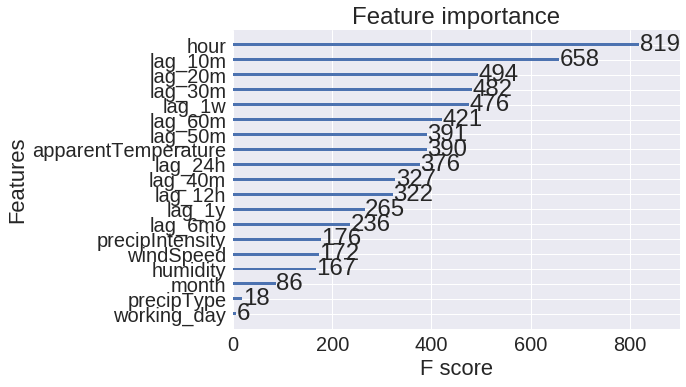

In [31]:
## Now let's fit the model with the best parameters
## Set the parameters for a grid search
params = {
    'n_estimators': 32,
    'max_depth': 8,
    'min_child_weight': 26,
    'gamma': 0,
    'subsample': 0.9,
    'colsample_bytree': 1,
    'colsample_bylevel': 0.85,
    'lambda': 0.9,
    'alpha': 0.3,
    'eta': 0.2,
    'nthread': 8,
    'eval_metric': 'rmse',
    'silent': 0,
    'objective': 'reg:linear'
}
xgb_train = xgb.DMatrix(train_X, label=train_y, feature_names=train_X.columns)
xgb_model = xgb.train(params, xgb_train, num_boost_round=45, verbose_eval=True)
xgb_test = xgb.DMatrix(test_X, feature_names=test_X.columns)
xgb_preds = xgb_model.predict(xgb_test)
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_preds))
xgb_r2 = r2_score(test_y, xgb_preds)
print("The root mean squared error is", xgb_rmse)
print("The percent of variance explained by the model is", xgb_r2)
xgb.plot_importance(xgb_model)

The average root mean squared error is 10.4290474746 +/- 1.71039265712
The average percent of variance explained by the model is 0.938847874445 +/- 0.0117675413586


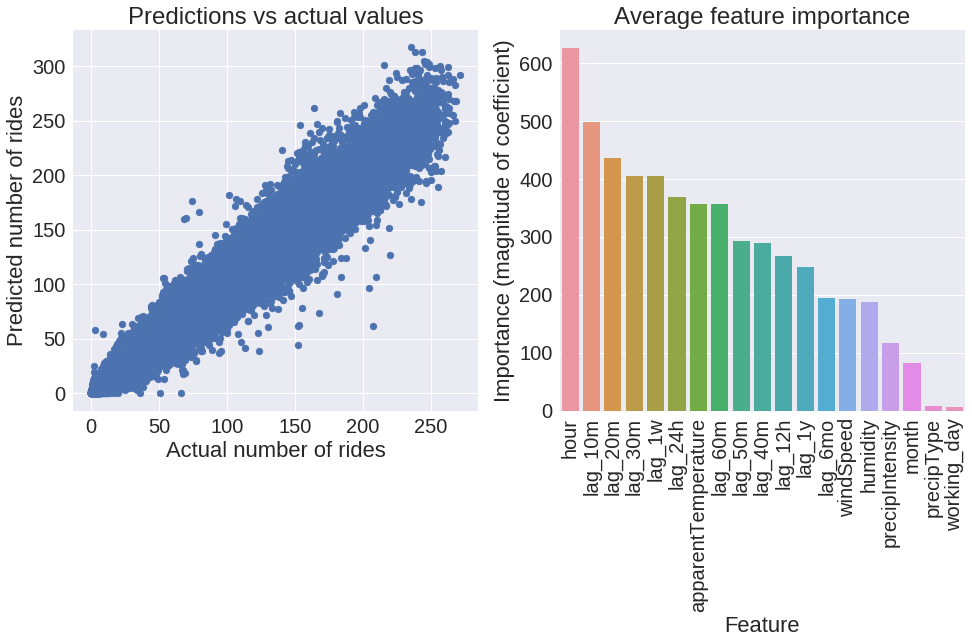

In [32]:
## Now let's fit the model with the various cv sets and get the averages for an apples to apples comparison with the other methods.
## Set the parameters for a grid search
params = {
    'n_estimators': 32,
    'max_depth': 8,
    'min_child_weight': 26,
    'gamma': 0,
    'subsample': 0.9,
    'colsample_bytree': 1,
    'colsample_bylevel': 0.85,
    'lambda': 0.9,
    'alpha': 0.3,
    'eta': 0.2,
    'nthread': 8,
    'eval_metric': 'rmse',
    'silent': 0,
    'objective': 'reg:linear'
}

tscv = TimeSeriesSplit(n_splits=10)
## Define the function do do the regression fitting and predicting
def doCV(tr_X, tr_y, ts_X):
    xgb_train = xgb.DMatrix(tr_X, label=tr_y, feature_names=tr_X.columns)
    xgb_model = xgb.train(params, xgb_train, num_boost_round=45, verbose_eval=True)
    xgb_test = xgb.DMatrix(ts_X, feature_names=ts_X.columns)
    xgb_preds = xgb_model.predict(xgb_test)
    return xgb_model, xgb_preds
## Fit and predict the splits
xgb_rmse = []
xgb_variance = []
xgb_coefs = []
X_trains = []
y_trains = []
X_tests = []
y_tests = []
xgb_models = []
xgb_preds = []
for train_index, test_index in tscv.split(train_X):
    X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
    X_trains.append(X_train)
    X_tests.append(X_test)
    y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
    y_trains.append(y_train)
    y_tests.append(y_test)
    xgb_model, xgb_pred = doCV(X_train, y_train, X_test)
    xgb_models.append(xgb_model)
    xgb_preds.append(xgb_pred)
    xgb_rmse.append(np.sqrt(mean_squared_error(y_test, xgb_pred)))
    xgb_coefs.append(xgb_model.get_score())
    xgb_variance.append(r2_score(xgb_pred, y_test))

print("The average root mean squared error is", np.mean(xgb_rmse), "+/-", np.std(xgb_rmse))
print("The average percent of variance explained by the model is", np.mean(xgb_variance), "+/-", np.std(xgb_variance))
sns.set(font_scale = 2)
plt.figure(figsize = [16,7])
plt.subplot(1,2,1)
plt.scatter(xgb_models[-1].predict(xgb.DMatrix(test_X, feature_names = test_X.columns)), test_y)
plt.title('Predictions vs actual values')
plt.ylabel('Predicted number of rides')
plt.xlabel('Actual number of rides')
plt.subplot(1,2,2)
xgb_feature_importances = pd.DataFrame(xgb_coefs)
coefs = pd.DataFrame([(x,y) for (y,x) in sorted(zip(xgb_feature_importances.mean(axis = 0), xgb_feature_importances.columns), reverse = True)], 
                     columns = ['Feature', 'Importance (magnitude of coefficient)'])
sns.barplot(x = 'Feature', y = 'Importance (magnitude of coefficient)', data = coefs)
plt.xticks(rotation=90)
plt.title('Average feature importance')
plt.ylabel('Importance (magnitude of coefficient)')

# xgb_train = xgb.DMatrix(train_X, label=train_y, feature_names=train_X.columns)
# xgb_model = xgb.train(params, xgb_train, num_boost_round=45, verbose_eval=True)
# xgb_test = xgb.DMatrix(test_X, feature_names=test_X.columns)
# xgb_preds = xgb_model.predict(xgb_test)
# xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_preds))
# xgb_r2 = r2_score(test_y, xgb_preds)
# print "The root mean squared error is", xgb_rmse
# print "The percent of variance explained by the model is", xgb_r2
# xgb.plot_importance(xgb_model)

In [33]:
## So a summary of our models is as follows:
## 1) Linear regression - rmse = 11.244; r^2 = 0.935
## 2) Random forest - rmse = 10.545; r^2 = 0.943
## 3) XGBoost using tree booster - rmse 10.431; r^2 = 0.0.939
## The random forest and XGBoost models perform similarly and are better than the linear regression.
## The linear regression, however, is by far the quickest and would be most useful for an online prediction.

### Individual station ridership

In [34]:
## Now let's implement models for the stations.
## This will be a bit difficult for those without much variability in bikes/docks, so we will have to use a different approach (like an EWMA).
## First let's get a measure of variability for each station and rank them. I'll count the number of changes in bikes for each station as my metric.

In [35]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
## Import the libraries for modeling
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import scipy as sp

In [36]:
## Import the master data
df = pd.read_csv('../data/historical_data/master_historical_data.csv', index_col = 0)
df.head()

/usr/lib64/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,account_type,bike_id,duration,end_datetime,end_station,start_datetime,start_station,start_time,end_time,start_date,...,cloudCover,pressure,holiday,working_day,year,month,season,hour,apparentTemperatureRounded,windSpeedRounded
0,1,861,932000,2011-01-01 11:27:00,31216.0,2011-01-01 11:12:00,31103,11:12,11:27,2011-01-01,...,0.47,1019.99,0,0,2011,1,Winter,11,45.0,9.0
1,1,89,326000,2011-01-01 16:19:00,31105.0,2011-01-01 16:13:00,31101,16:13,16:19,2011-01-01,...,0.84,1016.41,0,0,2011,1,Winter,16,53.0,8.0
2,1,395,598000,2011-01-01 16:23:00,31110.0,2011-01-01 16:13:00,31106,16:13,16:23,2011-01-01,...,0.84,1016.41,0,0,2011,1,Winter,16,53.0,8.0
3,0,752,869000,2011-01-01 16:29:00,31216.0,2011-01-01 16:14:00,31219,16:14,16:29,2011-01-01,...,0.84,1016.41,0,0,2011,1,Winter,16,53.0,8.0
4,1,279,741000,2011-01-01 16:26:00,31500.0,2011-01-01 16:14:00,31401,16:14,16:26,2011-01-01,...,0.84,1016.41,0,0,2011,1,Winter,16,53.0,8.0


In [ ]:
## Let's add columns counting the change in bikes for the start and end stations for each entry.
start_counts = df.loc[df.end_station.notnull()][['start_datetime', 'start_station', 'year']].groupby(['start_station', 'start_datetime'], as_index = False).count()
start_counts.columns = ['station_id', 'datetime', 'departures']
start_counts.station_id = start_counts.station_id.astype(int)
start_counts.set_index(['station_id', 'datetime'], drop = True, inplace = True)
start_counts.head()

departures
station_id datetime                       
31000      2011-01-07 09:52:00           1
           2011-01-07 12:51:00           1
           2011-01-08 00:08:00           1
           2011-01-08 14:06:00           1
           2011-01-09 12:21:00           1

In [ ]:
## Now ends
end_counts = df.loc[df.end_station.notnull()][['end_datetime', 'end_station', 'year']].groupby(['end_station', 'end_datetime'], as_index = False).count()
end_counts.columns = ['station_id', 'datetime', 'arrivals']
end_counts.station_id = end_counts.station_id.astype(int)
end_counts.set_index(['station_id', 'datetime'], drop = True, inplace = True)
end_counts.head()

In [5]:
## Calculate changes in bikes
bike_changes = start_counts.join(end_counts, how = 'outer')
bike_changes.fillna(value = 0, inplace = True)
bike_changes['bike_diff'] = (bike_changes.arrivals - bike_changes.departures).astype(int)
bike_changes.drop(['departures', 'arrivals'], axis = 1, inplace = True)
## Group into bins of 10 minutes
bike_changes = pd.DataFrame(bike_changes)
bike_changes.reset_index(inplace = True)
bike_changes['datetime'] = bike_changes.datetime.apply(pd.to_datetime)
bike_changes['datetime'] = bike_changes.datetime.apply(lambda x: x - datetime.timedelta(minutes = x.minute % 10))
bike_bins = bike_changes.groupby(['station_id', 'datetime'], as_index = False).sum()
## Make variability metric by adding up the magnitude of all the changes
bike_bins['bike_diff_abs'] = bike_bins.bike_diff.apply(np.abs)
bike_variability = bike_bins[['station_id','datetime','bike_diff_abs']].groupby('station_id').sum()
bike_variability.head()

,bike_diff_abs
station_id,
31000,6093
31001,20819
31002,47157
31003,34020
31004,21732


In [14]:
bike_variability.to_csv('../data/historical_data/variability_in_bike_availability_by_station.csv')
bike_bins.to_csv('../data/historical_data/changes_in_bike_availability_over_time_by_station.csv')

In [6]:
## Let's look at the stations with the least and the most usage.
bike_variability.sort_values('bike_diff_abs', inplace = True)
bike_variability.head(5), bike_variability.tail(5)

(            bike_diff_abs
 station_id               
 31713                   4
 31999                  88
 31709                 135
 31811                 149
 31912                 152,             bike_diff_abs
 station_id               
 31229              213967
 31101              218490
 31201              234583
 31623              287065
 31200              303343)

/usr/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log
/usr/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log


Number of stations in bottom half of usage: 341 (85.0%)
Number of stations in bottom half of usage: 62 (15.0%)


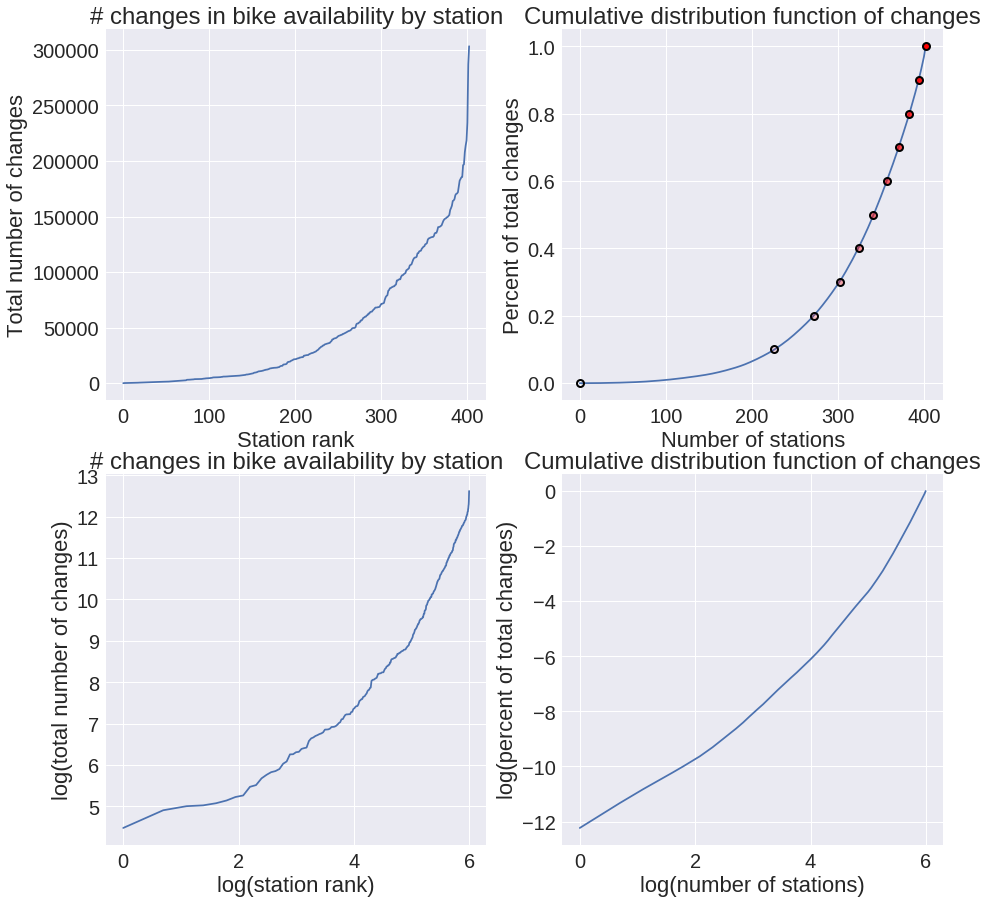

In [8]:
## Let's plot the usage by station to get an idea of the overall system usage.
sns.set(font_scale = 2)
plt.figure(figsize = [15, 15])
plt.subplot(2,2,1)
plt.plot(range(bike_variability.shape[0]), bike_variability.bike_diff_abs.values)
# sns.pointplot(x=bike_variability.index, y='bike_diff', data = bike_variability, order = bike_variability.index)
plt.title('# changes in bike availability by station')
plt.ylabel('Total number of changes')
plt.xlabel('Station rank')
plt.subplot(2,2,2)
cdf_data = np.cumsum(bike_variability.bike_diff_abs.values)
cdf_data = cdf_data / cdf_data[-1].astype(float)
zero_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0).argmin()])[0][0]
ten_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.1).argmin()])[0][0]
twenty_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.2).argmin()])[0][0]
thirty_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.3).argmin()])[0][0]
forty_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.4).argmin()])[0][0]
fifty_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.5).argmin()])[0][0]
sixty_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.6).argmin()])[0][0]
seventy_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.7).argmin()])[0][0]
eighty_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.8).argmin()])[0][0]
ninety_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 0.9).argmin()])[0][0]
hundred_percent_index = np.where(cdf_data == cdf_data.flat[np.abs(cdf_data - 1).argmin()])[0][0]
plt.plot(cdf_data)
plt.plot(zero_percent_index, 0, 'ro', alpha = 0.0, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(zero_percent_index, 0, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(ten_percent_index, 0.1, 'ro', alpha = 0.1, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(ten_percent_index, 0.1, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(twenty_percent_index, 0.2, 'ro', alpha = 0.2, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(twenty_percent_index, 0.2, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(thirty_percent_index, 0.3, 'ro', alpha = 0.3, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(thirty_percent_index, 0.3, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(forty_percent_index, 0.4, 'ro', alpha = 0.4, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(forty_percent_index, 0.4, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(fifty_percent_index, 0.5, 'ro', alpha = 0.5, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(fifty_percent_index, 0.5, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(sixty_percent_index, 0.6, 'ro', alpha = 0.6, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(sixty_percent_index, 0.6, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(seventy_percent_index, 0.7, 'ro', alpha = 0.7, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(seventy_percent_index, 0.7, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(eighty_percent_index, 0.8, 'ro', alpha = 0.8, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(eighty_percent_index, 0.8, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(ninety_percent_index, 0.9, 'ro', alpha = 0.9, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(ninety_percent_index, 0.9, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.plot(hundred_percent_index, 1, 'ro', alpha = 1, fillstyle='full', markeredgecolor='black', markeredgewidth=0)
plt.plot(hundred_percent_index, 1, 'ro', alpha = 1, fillstyle='none', markeredgecolor='black', markeredgewidth=2)
plt.title('Cumulative distribution function of changes')
plt.ylabel('Percent of total changes')
plt.xlabel('Number of stations')
plt.subplot(2,2,3)
plt.plot(np.log(range(bike_variability.shape[0])), np.log(bike_variability.bike_diff_abs.values))
plt.title('# changes in bike availability by station')
plt.ylabel('log(total number of changes)')
plt.xlabel('log(station rank)')
plt.subplot(2,2,4)
plt.plot(np.log(range(bike_variability.shape[0])), np.log(cdf_data))
plt.title('Cumulative distribution function of changes')
plt.ylabel('log(percent of total changes)')
plt.xlabel('log(number of stations)')
print("Number of stations in bottom half of usage: " + str(fifty_percent_index) + " (" + str(round(100 * fifty_percent_index / float(bike_variability.shape[0]))) +"%)")
print("Number of stations in bottom half of usage: " + str(bike_variability.shape[0] - fifty_percent_index)
      + " (" + str(round(100 * (bike_variability.shape[0] - fifty_percent_index) / float(bike_variability.shape[0]))) +"%)")

In [ ]:
## The bikeshare network usage is distributed in a power law-like fashion (although not quite a power law).
## We can see that many stations are used very little while a small percent are used very much.

In [95]:
## Ideas to determine which stations have enough variability to model them with a regression:
## 1) Just model them all with a regression, see how they score individually, and fix the ones that score poorly.
## 2) Cluster stations by usage patterns and apply different models to different clusters. This should take into account the difference in max and min # bikes as well as the frequency of change.